In [ ]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

In [ ]:
#define Objective function and inequality constrains 
obj = lambda x: x[0]**2 + (x[1] - 3)**2
g1 = lambda x: x[1]**2 - 2*x[0]
g2 = lambda x: (x[1]-1)**2 + 5*x[0]-15
df_obj  = lambda x : torch.tensor([[2 * x[0], 2 * (x[1] - 3)]])
df_g1 = lambda x : torch.tensor([[-2, 2 * x[1]]])
df_g2 = lambda x: torch.tensor([[5, 2 * (x[1] - 1)]])

In [ ]:
def meritFunWeights(Lambda, weights,k):
  if k > 0:
    weights = torch.max(abs(Lambda), 0.5 *(weights + abs(Lambda)))
  else:
    weights = abs(Lambda)
  return weights

In [ ]:
def F_alpha(x,weights,alpha,s):
  G1=max(0, g1(x + alpha*s)) # constrain 1
  G2=max(0, g2(x + alpha*s)) # constrain 2
  return obj(x + alpha*s) +  weights[0,:] * G1 + weights[1,:]* G2

In [ ]:
def lineSearch(x,Lambda,weights,s,k):
    t = 0.3
    alpha = 1
    weights = meritFunWeights(Lambda, weights,k)
    if g1(x) <= 0:
       dg1_da = 0
    else:
      dg1_da= torch.matmul(df_g1(x), s)

    if g2(x) <= 0:
       dg2_da = 0
    else:
      dg2_da= torch.matmul(df_g2(x), s)

    dF_da = torch.matmul(df_obj(x), s) + (weights[0, :] * dg1_da + weights[1, :] * dg2_da)

    phi = lambda x, weights, alpha, t, dF_da: F_alpha(x, weights, 0, 0) + alpha * t * dF_da

    while phi(x, weights, alpha, t, dF_da) < F_alpha(x, weights, alpha, s):
        alpha = 0.5 * alpha
    return alpha, weights

In [ ]:
def BFGS(x,W, s, Lambda, alpha):
  lx_k = df_obj(x) + torch.matmul(Lambda.T, torch.tensor([g1(x),g2(x)]))
  lx_k_1 = df_obj(x + alpha*s) + torch.matmul(Lambda.T, torch.tensor([g1(x + alpha*s),g2(x + alpha*s )]))

  delta_l = lx_k_1 -lx_k
  
  Q = torch.matmul(torch.matmul((alpha*s).T, W), (alpha*s))
  if torch.matmul((alpha*s).T, delta_l.T) >= 0.2 * torch.matmul(torch.matmul((alpha*s).T, W), (alpha*s)):
        theta = 1
  else:
        theta = 0.8 * Q / (Q - torch.matmul((alpha*s).T, delta_l.T))
  y = theta * delta_l.T + (1 - theta) * torch.matmul(W, (alpha*s))
  W = W + torch.matmul(y, y.T) / torch.matmul(y.T, s) - torch.matmul(torch.matmul(W, s), torch.matmul(s.T, W)) / torch.matmul(torch.matmul(s.T, W), s)
  return W

In [ ]:
def LangMulticheck(Lambda,active):
    Lambda_check = 0
    if len(Lambda) == 0 or min(Lambda) > 0:
        Lambda_check  = 1
    else:
        Lambda_idx = np.argmin(np.array(Lambda))
        Lambda = Lambda[Lambda!=min(Lambda)]
        active.pop(Lambda_idx)
    return active, Lambda_check ,Lambda

In [ ]:
def solve_sqp(x, W):
    active = []
    A_initial = torch.cat((df_g1(x),df_g2(x)),0)
    B_initial=torch.tensor([[g1(x), g2(x)]]).T
    Lambda_initial = torch.zeros((B_initial.shape[0], 1))
    Lambda = []
    while True:
      if len(active) == 0:
            s_Lambda = torch.matmul(torch.linalg.inv(W), -df_obj(x).T)
            s = s_Lambda[:2, :]
      if len(active) > 0:
        if len(active) == 1:
                A = A_initial[active[0], :].reshape(1, -1)
                B = B_initial[active[0], :].reshape(1,1)
        if len(active) == 2:
                A = A_initial
                B = B_initial
                
        Z = torch.zeros((A.shape[0], A.shape[0]))
        matrix=torch.cat((torch.cat((W,A.T),1),torch.cat((A,Z),1)),0)
        j=torch.cat((-df_obj(x).T,-B),0)
        s_Lambda = torch.matmul(torch.linalg.inv(matrix), j)
        s = s_Lambda[:2, :]
        Lambda = s_Lambda[2:, :]

      if len(Lambda) == 1:
          Lambda_initial[0] = s_Lambda[2:3, :]
      if len(Lambda) == 2:
          Lambda_initial[0] = s_Lambda[2:3, :]
          Lambda_initial[1] = s_Lambda[3:, :]

      sqp_constraint = torch.round((torch.matmul(A_initial, s.reshape(-1, 1)) + B_initial))
      active, mu_check,Lambda = LangMulticheck(Lambda,active)

      if torch.max(sqp_constraint) <= 0 and mu_check == 1:
            return s, Lambda_initial
      else:
          index = np.argmax(sqp_constraint)
          active.append(index)
          active = np.unique(np.array(active)).tolist()

In [ ]:
x = torch.tensor([[1,1.]]).T
x_initial = x
Lambda = torch.zeros((x.shape[0], 1))
weights = torch.zeros((x.shape[0], 1))+2
W = torch.eye(x.shape[0])
eps = 1e-4
k = 0

delta_L_norm = np.linalg.norm(df_obj(x) + np.matmul(Lambda.T, torch.cat((df_g1(x),df_g2(x)),0)))

while delta_L_norm > eps:
    s, Lambda = solve_sqp(x, W)
    a, weights = lineSearch(x,Lambda,weights,s,k)
    weights_old = weights
    W = BFGS(x,W, s, Lambda, a) 
    x += a*s
    k += 1
    delta_L_norm = np.linalg.norm(df_obj(x) + np.matmul(Lambda.T, torch.cat((df_g1(x),df_g2(x)),0)))

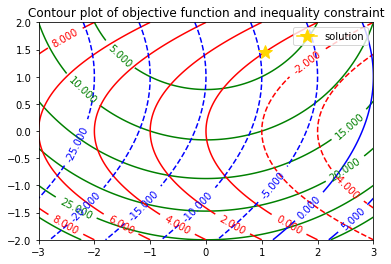

In [ ]:
X1 = np.linspace(-3, 3, 100)
X2 = np.linspace(-2, 2, 100)
# cartesian combination of X1 and X2 vectors
param_grid = np.array([[C, x2] for x2 in X2 for C in X1])
real = [obj(params) for params in param_grid]
real_g1 = [g1(params) for params in param_grid]
real_g2 = [g2(params) for params in param_grid]

C, G = np.meshgrid(X1, X2)

fig, ax = plt.subplots()
CS = ax.contour(C, G, np.array(real).reshape(C.shape), colors='g')
ax.clabel(CS, inline=True, fontsize=10)
CS1 = ax.contour(C, G, np.array(real_g1).reshape(C.shape), colors='r')
ax.clabel(CS1, inline=True, fontsize=10)
CS2 = ax.contour(C, G, np.array(real_g2).reshape(C.shape), colors='b')
ax.clabel(CS2, inline=True, fontsize=10)

plt.plot(x[0], x[1], c='gold', marker='*', markersize='15', label='solution')
plt.legend()

plt.title('Contour plot of objective function and inequality constraint')
plt.show()

In [ ]:
print('Solution for this problem is: X=({},{})'.format(x[0][0], x[1][0]))

Solution for this problem is: X=(1.0602166652679443,1.4561707973480225)


Verify the solution

In [ ]:
print('The minumim value of objective function is {}'.format(obj([x[0][0],x[1][0]])))
print("The inequality constraints are:\ng1={}\ng2={}".format(g1([x[0][0],x[1][0]]),g2([x[0][0],x[1][0]])))

The minumim value of objective function is 3.507467746734619
The inequality constraints are:
g1=0.0
g2=-9.490824699401855
